In [1]:
from keras.models import load_model
from keras.metrics import MeanIoU
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
import os
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf 

n_classes = 2

In [2]:
val_images_path = r'.\dataset\Forest Segmented\train_data\val_image\val'
val_masks_path = r'.\dataset\Forest Segmented\train_data\val_mask\val'
num_val_images = len(os.listdir(val_images_path))

Загрузка тестовых изображений и масок

In [3]:
def load_data(image_path, size=(256,256)):
    img_list = list()
    images = sorted(os.listdir(image_path))
    for i in range(len(images)):      
        img_pixels = load_img(os.path.join(image_path, images[i]), target_size=size)
        img = img_to_array(img_pixels)
        img = img.astype("float") / 255.0
        img_list.append(img)

      
    return np.asarray(img_list)

In [4]:
def load_test_masks(masks_path, size=(256, 256)):
    mask_list = list()
    masks = sorted(os.listdir(masks_path))
    for i in range(len(masks)):      
        mask = cv2.imread(os.path.join(masks_path, masks[i]), cv2.IMREAD_GRAYSCALE)
        mask_list.append(mask)
    
    return np.asarray(mask_list)


In [5]:
test_masks = load_test_masks(val_masks_path)
test_images = load_data(val_images_path)


Оценка автоэнкодера

In [6]:
model = load_model(r'.\models\Method1_Model.h5', compile=False)
test_pred_autoencoder = model.predict(test_images, steps=num_val_images)
test_pred_autoencoder_argmax = np.argmax(test_pred_autoencoder, axis=3)

1277/1277 [==============================] - 17s 11ms/step


In [7]:
IOU_Autoencoder = MeanIoU(num_classes=n_classes)  
IOU_Autoencoder.update_state(test_pred_autoencoder_argmax, test_masks)

print("Mean Autoencoder IoU =", IOU_Autoencoder.result().numpy()) 

Mean Autoencoder IoU = 0.5490402


In [8]:
def gan_rgb_to_2D_label(label):
    thrshold = np.asarray((0.5, 0.5, 0.5))
    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg [np.where(label <=thrshold)] = 0
    label_seg [np.where(label >= thrshold)] = 1
    return label_seg

def gan_post_proccess(preds):
    results = []
    for pred in preds:
        r = gan_rgb_to_2D_label(pred)
        r = r[:,:,0]
        results.append(r)
    
    return np.asarray(results)


Оценка условно порождающей состязательной сети

In [9]:
model = load_model(r'.\models\Method2_Model.h5', compile=False)
test_pred_gan = model.predict(test_images, steps=num_val_images, verbose=0)
test_pred_gan_argmax = gan_post_proccess(test_pred_gan)

c:\ProgramData\Anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [8]:
IOU_GAN = MeanIoU(num_classes=n_classes)
IOU_GAN.update_state(test_pred_gan_argmax, test_masks)

print("Mean GAN IoU =", IOU_GAN.result().numpy()) 

Mean GAN IoU = 0.37054902


Визуальное сравнение

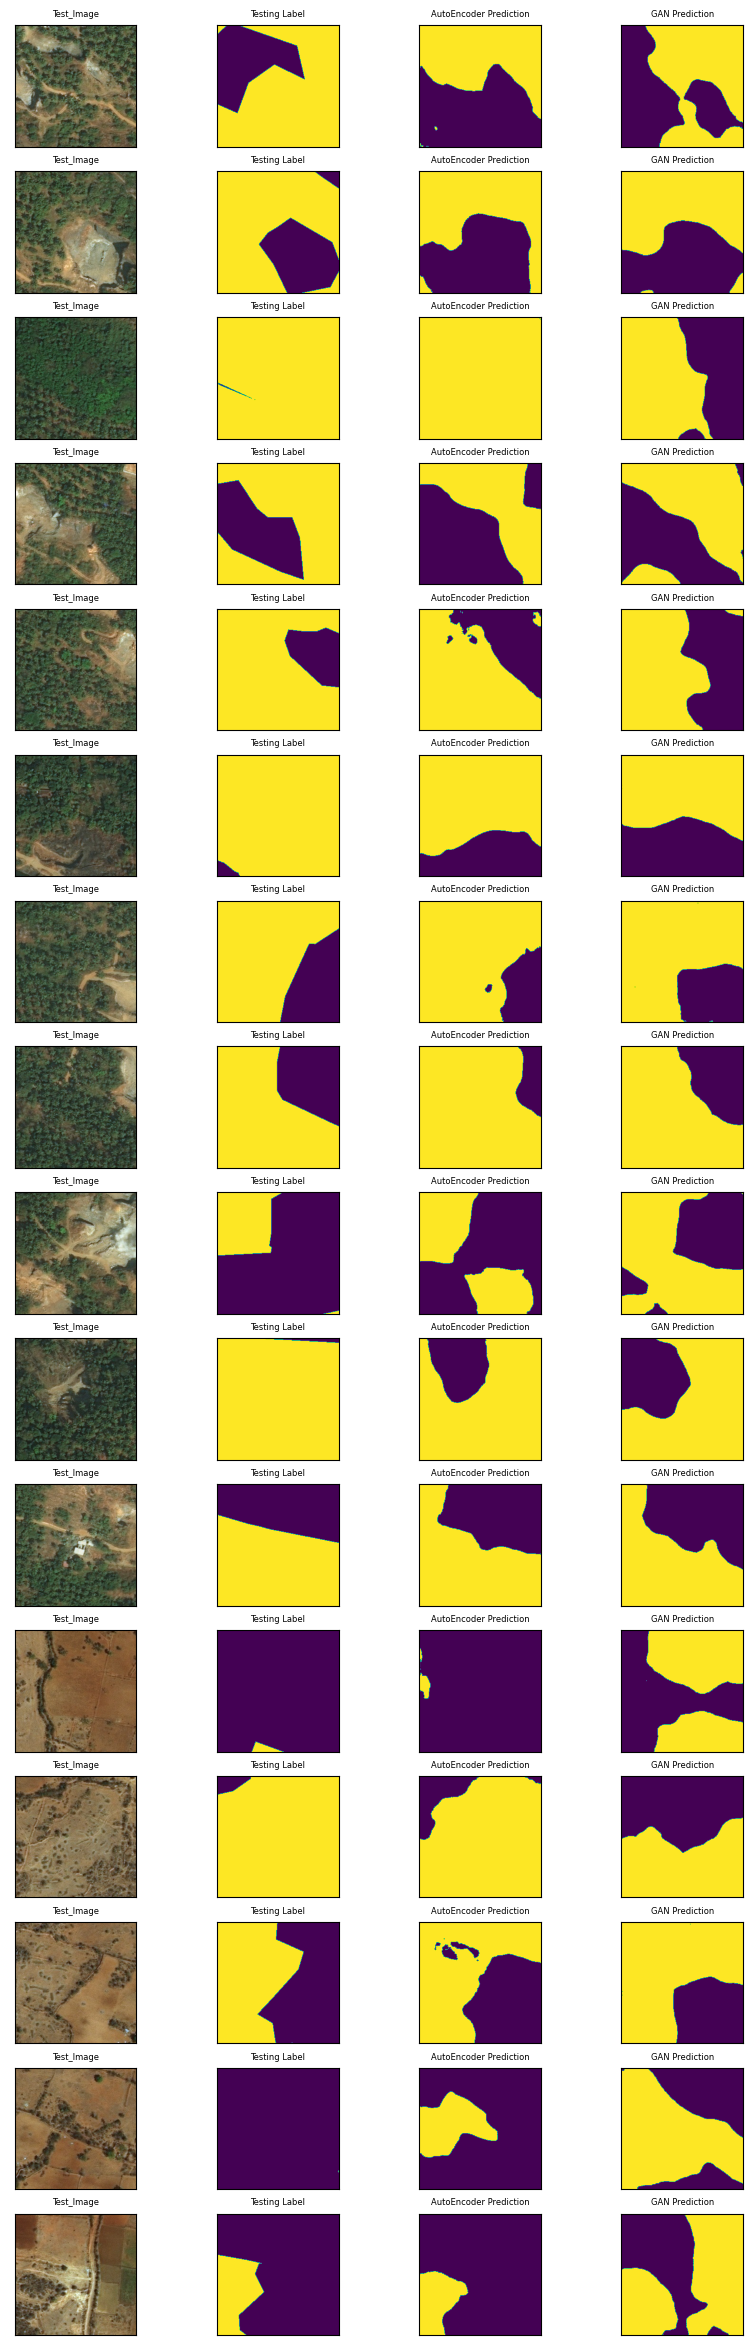

In [12]:
images_number = 16

fig, axis = plt.subplots(images_number, 4)
fig.set_figwidth(10)
fig.set_figheight(30)

for img_num in range(images_number):   
    
    axis[img_num][0].imshow(test_images[img_num])
    axis[img_num][0].set_title('Test_Image', fontsize = 6)
    axis[img_num][0].axes.xaxis.set_visible(False)
    axis[img_num][0].axes.yaxis.set_visible(False)


    axis[img_num][1].imshow(test_masks[img_num])
    axis[img_num][1].set_title("Testing Label", fontsize = 6)
    axis[img_num][1].axes.xaxis.set_visible(False)
    axis[img_num][1].axes.yaxis.set_visible(False)

    axis[img_num][2].imshow(test_pred_autoencoder_argmax[img_num])
    axis[img_num][2].set_title("AutoEncoder Prediction", fontsize = 6)
    axis[img_num][2].axes.xaxis.set_visible(False)
    axis[img_num][2].axes.yaxis.set_visible(False)

    axis[img_num][3].imshow(test_pred_gan_argmax[img_num])
    axis[img_num][3].set_title("GAN Prediction", fontsize = 6)
    axis[img_num][3].axes.xaxis.set_visible(False)
    axis[img_num][3].axes.yaxis.set_visible(False)

    
plt.show()

# Вывод
Используемая метрика нам показала, что Автоэнкодер точнее справляется с задачей чем GAN. 
Причиной этому может быть то, что GAN недостаточно обучен, и мог бы показать и лучший результат, однако в связи с временными ограничениями это проверить не удастся.
Также стоит отметить, что оценка IoU, у обеих моделей довольно низкая, что особенно не свойственно Автоэнкодеру при решении данной задачи. Скорей всего это связано с тем, что сама маска является довольно неточной, и зачастую на визуальных примерах видно, что Автоэнкодер, а иногда и GAN, гораздо более точно отображают маску, чем представленная  маска.
Это и показывает преимущество использования нейронных сетей в целях сегментации, так как взяв маски не лучшим образом нарисованные человеком, мы можем обучить нейросеть, которая будет делать это лучше и точнее.